# Problem 1


**Q1** This subcephalic superthoracic organ is ventral with regard to midfrontal coronal plane and includes dextral and sinistral lobes which are equidistant from the midsagittal plane.” What organ is this radiologist talking about? What modality is the safest and the most reasonable choice for imaging its cranial-caudal motus?

**Answer:** 
The organ is the thyroid gland. Ultrasound is the safest and most reasonable choice.

**Q2** What is the Fourier Transform of the Point Spread Function? Which computer tomography machine is more expensive: the one that has a large value of the integral under the curve of this transform; or the one with a small value?

**Answer:**
It is modulation transfer function (MTF): $H(u,v) = F(h(x,y))$. The machine with a large value under the integral curve is more expensive.

**Q3** What is the major difference between a phase contrast microscope and a confocal microscope?

**Answer:**
Phase‑contrast boosts contrast across the whole volume, whereas confocal removes out‑of‑focus light to achieve optical sectioning and much cleaner images at the cost of much slower speed.

**Q4** How much of X-ray radiation (in mSv) is transmitted to a patient during a typical dental X-ray? How does that compare to the natural radiation background on the Earth?

**Answer:**
Dental X‑ray is 0.005 mSv. It is comparable to 1 day of natural background radiation.

# Problem 2

## Problem 2.1.

(777, 1202)


(np.float64(-0.5), np.float64(1201.5), np.float64(776.5), np.float64(-0.5))

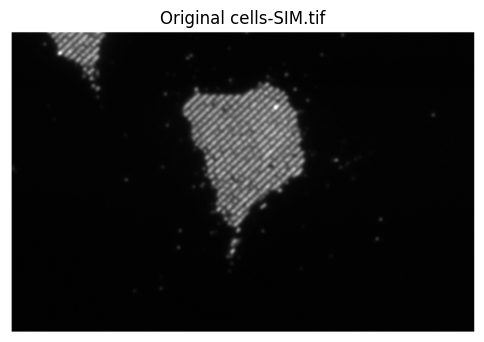

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform, filters, measure
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

img_orig = io.imread("cells-SIM.tif")

print(img_orig.shape)

plt.figure(figsize=(6, 4))
plt.imshow(img_orig, cmap="gray")
plt.title("Original cells‑SIM.tif")
plt.axis("off")

(np.float64(-0.5), np.float64(1201.5), np.float64(776.5), np.float64(-0.5))

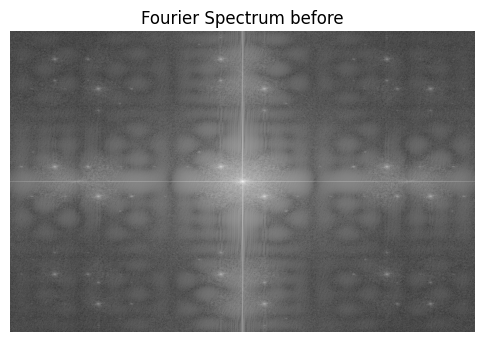

In [138]:
img = np.copy(img_orig)

# Remove white border
img[:10, :10] = 0
img[:10, -10:] = 0
img[-10:, -10:] = 0
img[-10:, :10] = 0

F = np.fft.fft2(img)
F_shift = np.fft.fftshift(F)

plt.figure(figsize=(6, 4))
plt.imshow(np.log(1 + np.abs(F_shift)), cmap="gray")
plt.title("Fourier Spectrum before")
plt.axis("off")

(np.float64(-0.5), np.float64(1201.5), np.float64(776.5), np.float64(-0.5))

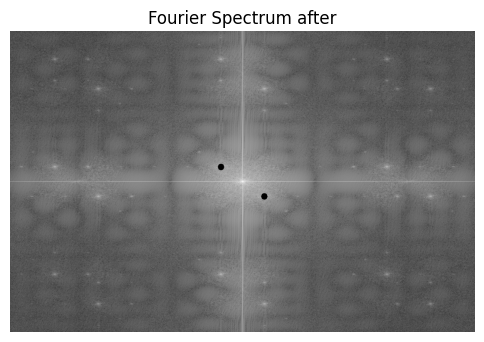

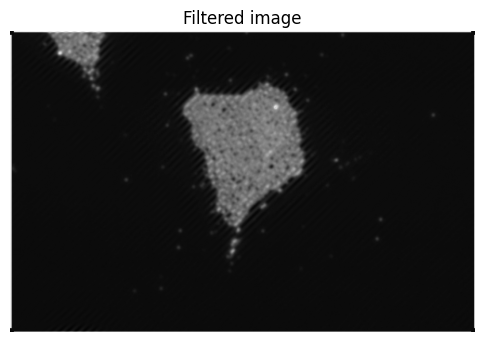

In [139]:
magnitude = np.log1p(np.abs(F_shift))
h, w = magnitude.shape
cy, cx = h // 2, w // 2
mask = np.ones_like(magnitude, bool)
mask[cy - 10 : cy + 11, :] = False
mask[:, cx - 10 : cx + 11] = False
mag_masked = magnitude * mask

inds = np.dstack(np.unravel_index(np.argsort(mag_masked.ravel())[-2:], magnitude.shape))[0]
peaks = [(int(y), int(x)) for y, x in inds]

# Create notch filter zeros around peaks and their mirrored positions
notch = F_shift.copy()
for y, x in peaks + [(h - y, w - x) for y, x in peaks]:
    yy, xx = np.ogrid[:h, :w]
    mask_disk = (yy - y) ** 2 + (xx - x) ** 2 <= 8**2
    notch[mask_disk] = 0

plt.figure(figsize=(6, 4))
plt.imshow(np.log(1 + np.abs(notch)), cmap="gray")
plt.title("Fourier Spectrum after")
plt.axis("off")

F_notch = np.fft.ifftshift(notch)
img_filtered = np.real(np.fft.ifft2(F_notch))

plt.figure(figsize=(6, 4))
plt.imshow(img_filtered, cmap="gray")
plt.title("Filtered image")
plt.axis("off")


(np.float64(-0.5), np.float64(1201.5), np.float64(776.5), np.float64(-0.5))

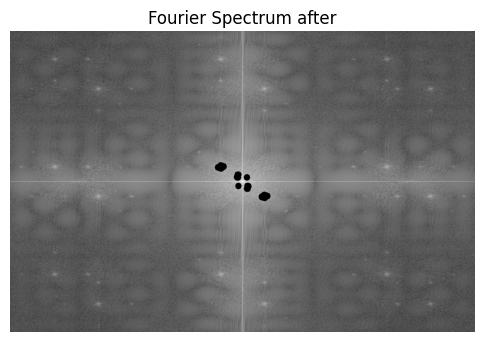

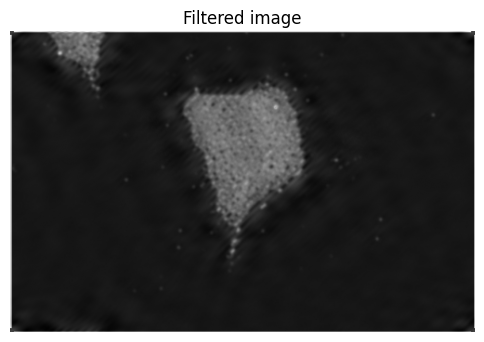

In [140]:
# Try more peaks
inds = np.dstack(np.unravel_index(np.argsort(mag_masked.ravel())[-100:], magnitude.shape))[0]
peaks = [(int(y), int(x)) for y, x in inds]

notch = F_shift.copy()
for y, x in peaks + [(h - y, w - x) for y, x in peaks]:
    yy, xx = np.ogrid[:h, :w]
    mask_disk = (yy - y) ** 2 + (xx - x) ** 2 <= 8**2
    notch[mask_disk] = 0

plt.figure(figsize=(6, 4))
plt.imshow(np.log(1 + np.abs(notch)), cmap="gray")
plt.title("Fourier Spectrum after")
plt.axis("off")

F_notch = np.fft.ifftshift(notch)
img_filtered = np.real(np.fft.ifft2(F_notch))

plt.figure(figsize=(6, 4))
plt.imshow(img_filtered, cmap="gray")
plt.title("Filtered image")
plt.axis("off")

(np.float64(-0.5), np.float64(1201.5), np.float64(776.5), np.float64(-0.5))

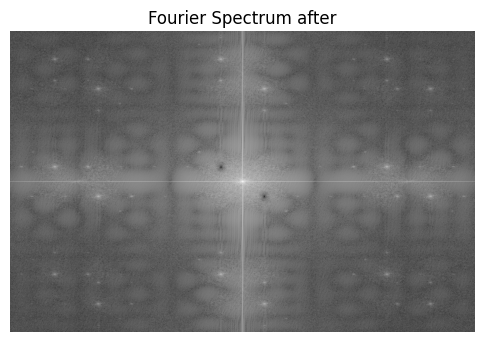

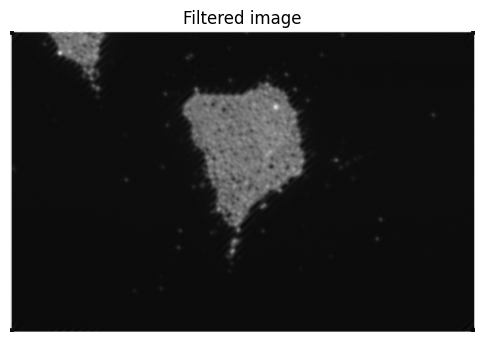

In [141]:
# Try gaussian filter

inds = np.dstack(np.unravel_index(np.argsort(mag_masked.ravel())[-2:], magnitude.shape))[0]
peaks = [(int(y), int(x)) for y, x in inds]

# 5) Build a 2D Gaussian notch filter
U, V = np.meshgrid(np.arange(w) - cx, np.arange(h) - cy)
notch = np.ones_like(F_shift, float)
sigma = 10.0
for y, x in peaks + [(h - y, w - x) for y, x in peaks]:
    notch *= 1 - np.exp(-(((V - (y - cy)) ** 2 + (U - (x - cx)) ** 2) / (2 * sigma**2)))

notch = F_shift * notch

plt.figure(figsize=(6, 4))
plt.imshow(np.log(1 + np.abs(notch)), cmap="gray")
plt.title("Fourier Spectrum after")
plt.axis("off")

F_notch = np.fft.ifftshift(notch)
img_filtered = np.real(np.fft.ifft2(F_notch))

plt.figure(figsize=(6, 4))
plt.imshow(img_filtered, cmap="gray")
plt.title("Filtered image")
plt.axis("off")

(np.float64(-0.5), np.float64(1201.5), np.float64(776.5), np.float64(-0.5))

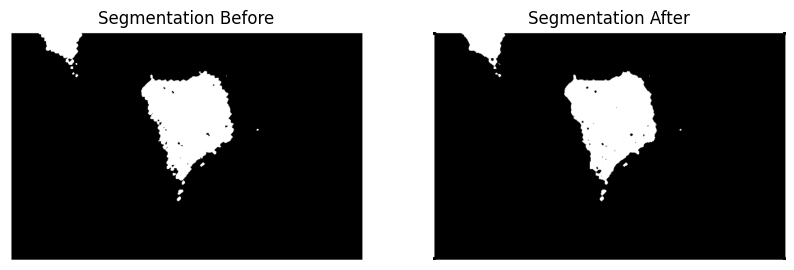

In [142]:
# Segmentation Before and After Filtering

th_before = filters.threshold_otsu(img_orig)
mask_before = img_orig > th_before

th_after = filters.threshold_otsu(img_filtered)
mask_after = img_filtered > th_after

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(mask_before, cmap="gray")
axes[0].set_title("Segmentation Before")
axes[0].axis("off")
axes[1].imshow(mask_after, cmap="gray")
axes[1].set_title("Segmentation After")
axes[1].axis("off")

In [143]:
# PSNR, SSIM and Area of the Central Cell

# Find the largest segmented region (the big cell), crop its region, and compute:
# - PSNR and SSIM between the raw ROI and the filtered ROI
# - Pixel area of the ROI before and after filtering

labels = measure.label(mask_after)
props = measure.regionprops(labels)
big_region = max(props, key=lambda r: r.area)
minr, minc, maxr, maxc = big_region.bbox

roi_before = img_orig[minr:maxr, minc:maxc]
roi_after = img_filtered[minr:maxr, minc:maxc]

dr = roi_before.max() - roi_before.min()
psnr_after = psnr(roi_before, roi_after, data_range=dr)
ssim_after = ssim(roi_before, roi_after, data_range=dr)

area_before = (roi_before > th_before).sum()
area_after = (roi_after > th_after).sum()

print(f"PSNR (before vs after):  {psnr_after:.2f} dB")
print(f"SSIM (before vs after):  {ssim_after:.3f}")
print(f"Area (before):           {area_before} px")
print(f"Area (after):            {area_after} px")

PSNR (before vs after):  24.21 dB
SSIM (before vs after):  0.685
Area (before):           71536 px
Area (after):            72373 px


## Problem 2.2. Fourier Transform of $f(x)=A\sin(x)+B$

$$
{F}(\omega)=\int_{-\infty}^\infty f(x)\,e^{-i\omega x}\,dx. \\
$$

**Constant term:**
$$
\int_{-\infty}^{\infty} B\,e^{-i\omega x}\,dx
= B\cdot 2\pi\,\delta(\omega).
$$

**Sinusoidal term:**  
$$
\sin x=\tfrac{e^{ix}-e^{-ix}}{2i} \\
\int_{-\infty}^{\infty} A\sin x\,e^{-i\omega x}\,dx
= \frac{A}{2i}\!\int(e^{i x}-e^{-i x})e^{-i\omega x}\,dx
= \frac{A}{2i}[
\int e^{-i(\omega-1)x}\,dx
- \int e^{-i(\omega+1)x}\,dx
] = \\
\frac{A}{2i}[2\pi\,\delta(\omega-1)
-2\pi\,\delta(\omega+1)]
= \pi A\,\frac{\delta(\omega-1)-\delta(\omega+1)}{i}.
$$

**Combine both:**
$$
\pi A\,\frac{\delta(\omega-1)-\delta(\omega+1)}{i}+2\pi B\,\delta(\omega)
$$

This matches why our notch filter zeros the spikes at $\omega=\pm1$ to remove the stripes.


## Problem 2.3. Using the stripe pattern as an advantage

That’s how structured illumination microscopy works. Instead of discarding the known stripe illumination, you can record several images with shifted stripe phases, and then combine them. This lets you pull out finer details than you could see with a single image, effectively beating the normal blur limit.

# Problem 3

(300, 721)


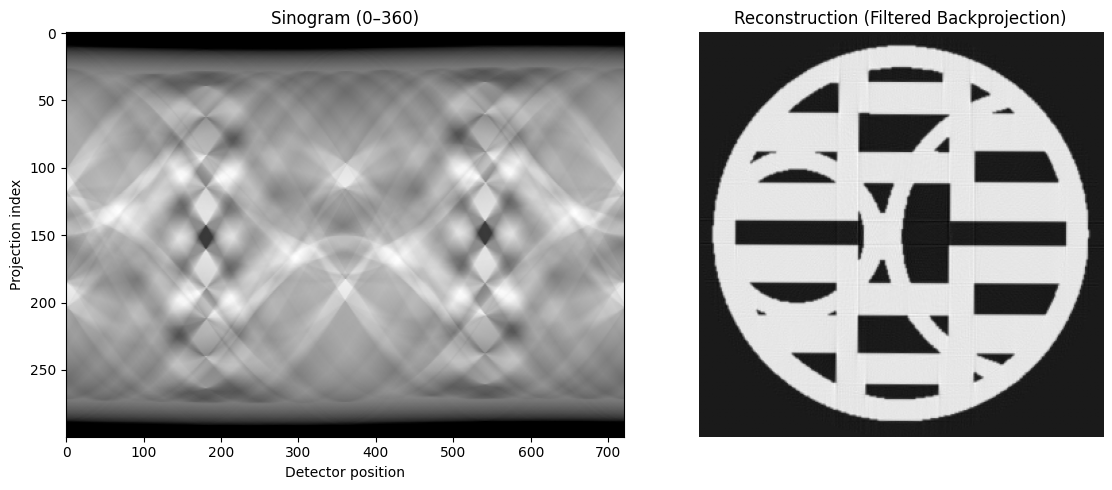

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import iradon

sinogram = np.loadtxt("sinogram.txt")

print(sinogram.shape)

n_detectors, n_angles = sinogram.shape

angles = np.linspace(0.0, 360.0, n_angles, endpoint=False)

reconstruction = iradon(sinogram, theta=angles, filter_name="ramp", circle=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(sinogram, cmap="gray", aspect="auto")
axes[0].set_title("Sinogram (0–360)")
axes[0].set_xlabel("Detector position")
axes[0].set_ylabel("Projection index")

axes[1].imshow(reconstruction, cmap="gray")
axes[1].set_title("Reconstruction (Filtered Backprojection)")
axes[1].axis("off")

plt.tight_layout()
plt.show()
